### 합성곱 신경망


In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

**데이터 불러오기**

In [2]:
(X_train_all, y_train_all), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [0]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42
)

In [0]:
# 원-핫 인코딩
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_val_encoded = tf.keras.utils.to_categorical(y_val)

In [0]:
X_train = X_train.reshape(-1, 28, 28, 1)
X_val = X_val.reshape(-1, 28, 28, 1)

In [7]:
X_train.shape

(48000, 28, 28, 1)

In [0]:
# 표준화
X_train = X_train / 255
X_val = X_val / 255

**합성곱 신경망 클래스 생성**

In [0]:
class ConvolutionNetwork:

  def __init__(self, n_kernels=10, units=10, batch_size=32, learning_rate=0.1):
    self.n_kernels = n_kernels
    self.kernel_size = 3
    self.optimizer = None
    self.conv_w = None
    self.conv_b = None
    self.units = units
    self.batch_size = batch_size
    self.w1 = None
    self.b1 = None
    self.w2 = None
    self.b2 = None
    self.a1 = None
    self.losses = []
    self.val_losses = []
    self.lr = learning_rate


  def init_weights(self, input_shape, n_classes):
    g = tf.initializers.glorot_uniform()  # 가중치 초기화 방법
    # 텐서플로우의 자동미분 기능을 사용하기 위해 tf.Variable()로 선언
    self.conv_w = tf.Variable(g((3, 3, 1, self.n_kernels)))
    # np.zeros()는 기본이 64비트인데, 23비트로 만들기 위해 dtype=float로 지정
    self.conv_b = tf.Variable(np.zeros(self.n_kernels), dtype=float)
    n_features = 14 * 14 * self.n_kernels

    self.w1 = tf.Variable(g((n_features, self.units)))
    self.b1 = tf.Variable(np.zeros(self.units), dtype=float)
    self.w2 = tf.Variable(g((self.units, n_classes)))
    self.b2 = tf.Variable(np.zeros(n_classes), dtype=float)


  def forpass(self, x):
    # 합성곱, 특성맵의 크기: 28x28x10
    # self.conv_w의 크기: 3x3x1x10
    c_out = tf.nn.conv2d(x, self.conv_w, strides=1, padding='SAME') + self.conv_b
    r_out = tf.nn.relu(c_out)  # ReLU 함수
    p_out = tf.nn.max_pool2d(r_out, ksize=2, strides=2, padding='VALID')  # 풀링

    # 풀링의 결과를 열벡터로 변환 후 완전 연결층에 연결
    f_out = tf.reshape(p_out, [x.shape[0], -1])
    z1 = tf.matmul(f_out, self.w1) + self.b1  # matmul() == np.dot()
    a1 = tf.nn.relu(z1)
    z2 = tf.matmul(a1, self.w2) + self.b2
    return z2


  def training(self, x, y):
    m = len(x)

    # 손실값 계산
    with tf.GradientTape() as tape:
      z = self.forpass(x)
      loss = tf.nn.softmax_cross_entropy_with_logits(y, z)
      loss = tf.reduce_mean(loss)  # 각 샘플에 대한 손실을 반환하므로 평균을 구함

    # 가중치와 절편 리스트
    weights_list = [self.conv_w, self.conv_b,
                    self.w1, self.b1, self.w2, self.b2]
    grads = tape.gradient(loss, weights_list)  # 변화율 계산
    self.optimizer.apply_gradients(zip(grads, weights_list))  # 가중치와 절편 업데이트


  def fit(self, x, y, epochs=100, x_val=None, y_val=None):
    self.init_weights(x.shape[1], y.shape[1])
    self.optimizer = tf.optimizers.SGD(learning_rate=self.lr)

    for i in range(epochs):
      batch_losses = []

      for x_batch, y_batch in self.gen_batch(x, y):
        self.training(x_batch, y_batch)
        batch_losses.append(self.get_loss(x_batch, y_batch))
      
      self.losses.append(np.mean(batch_losses))
      self.val_losses.append(self.get_loss(x_val, y_val))


  def gen_batch(self, x, y):
    length = len(x)
    bins = length // self.batch_size

    indexes = np.random.permutation(np.arange(len(x)))
    x = x[indexes]
    y = y[indexes]

    for i in range(bins):
      start = self.batch_size * i
      end = self.batch_size * (i + 1)
      yield x[start:end], y[start:end]


  def predict(self, x):
    z = self.forpass(x)
    return np.argmax(z.numpy(), axis=1)


  def score(self, x, y):
    return np.mean(self.predict(x) == np.argmax(y, axis=1))


  def get_loss(self, x, y):
    z = self.forpass(x)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y, z))
    return loss.numpy()

**모델 생성 & 훈련**

In [0]:
cn = ConvolutionNetwork(n_kernels=10, units=100, batch_size=128, learning_rate=0.01)
cn.fit(X_train, y_train_encoded, x_val=X_val, y_val=y_val_encoded, epochs=20)

In [11]:
print('모델 검증 점수: {:.2f}'.format(cn.score(X_val, y_val_encoded)))

모델 검증 점수: 0.87


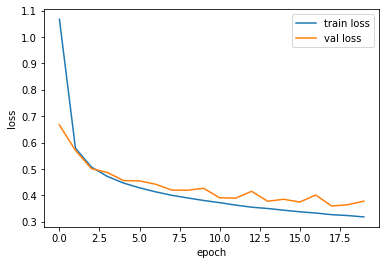

In [12]:
# 손실 그래프
plt.plot(cn.losses)
plt.plot(cn.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'])
plt.show()

### < 용어 정리 >

**1) 합성곱 신경망(CNN)**
- 이미지를 2차원 형태로 입력하여 합성곱(교차상관)과 풀링을 사용하여 만든 특성맵을 완전 연결 신경망으로 처리하는 신경망

**2) 합성곱**
- 곱하는 배열(가중치 배열)을 뒤집은 다음 원본 배열에 미끄러지듯 점 곱을 수행하여 특성맵을 구하는 연산법

**3) 풀링**
- 특성맵을 스캔하여 최대값을 선택하거나, 평균값을 계산하여 새로운 특성맵을 구하는 연산법